<a href="https://colab.research.google.com/github/DrDourado/UofL_ME_613_ML_Course/blob/main/ME_613_05_Introduction_to_Img_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 This notebook illustrates a simplified introductory image segmentation problem using the Oxford-IIIT Pets dataset from TensorFlow datasets. The notebook includes a simplfied U-Net neural network architecture for predicting image masks; model training using binary crossentropy as the loss function and the concept of Intersection over Union (IoU) as performance metric; and visualizations to help students understand the process.

In this notebook you'll find:

1. **Data Loading and Preprocessing**: The Oxford-IIIT Pets dataset is loaded using TensorFlow Datasets. The dataset consists of images with corresponding segmentation masks. The data is preprocessed to resize the images and masks and normalize the image data.

2. **Model Architecture**: A U-Net architecture is defined for image segmentation. U-Net is a popular convolutional neural network architecture for biomedical image segmentation tasks.

3. **Intersection over Union (IoU)**: IoU is a metric used to evaluate the performance of segmentation models. It measures the overlap between the predicted segmentation mask and the ground truth mask.

4. **Model Compilation and Training**: The model is compiled with binary cross-entropy loss and IoU metric. It is then trained on the training dataset for a specified number of epochs.

5. **Training History Visualization**: The training and validation IoU scores are plotted to visualize the model's performance during training.

6. **Example Predictions Visualization**: Example predictions are visualized to demonstrate the model's ability to segment objects in images. Each example includes the input image, true mask, and predicted mask.







In [ ]:
# Import necessary libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In an image classification task, the network assigns a label (or class) to each input image. However, suppose you want to know the shape of that object, rather than just it class. In this case, you need to assign a class to each pixel of the image, in a task known as segmentation. A segmentation model returns a prediction mask of the original image, highlighting the shapes of the desired classes.

In this notebook we'll use the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) ([Parkhi et al, 2012](https://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf)). The dataset consists of images of 37 pet breeds, with 200 images per breed (~100 each in the training and test splits). Each image includes the corresponding labels, and pixel-wise masks. The masks are class-labels for each pixel. Each pixel is given one of three categories:

- Class 1: Pixel belonging to the pet.
- Class 2: Pixel bordering the pet.
- Class 3: None of the above/a surrounding pixel.

The dataset is [available from TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet). The segmentation masks are included in version 3+.
The dataset already contains the required training and test splits.


In [ ]:
# Load Oxford-IIIT Pets dataset
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteOLQVTK/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteOLQVTK/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


Auxiliary Functions

In [ ]:
# Function to preprocess dataset
def preprocess_data(sample):
    image = tf.image.resize(sample['image'], (128, 128)) / 255.0  # Resize and normalize image
    mask = tf.image.resize(sample['segmentation_mask'], (128, 128))  # Resize mask
    mask = tf.where(mask == 2, 1, 0)  # Convert mask labels to binary (foreground/background)
    return image, mask

In [ ]:
# Function to estimate Intersection over Union (IoU) metric
def iou(y_true, y_pred):
    intersection = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    union = tf.reduce_sum(tf.cast(y_true + y_pred > 0, tf.float32))
    return intersection / (union + 1e-7)

In [ ]:
# Define U-Net architecture
def build_unet():
    inputs = tf.keras.layers.Input((128, 128, 3))

    # Encoder
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Decoder
    conv3 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv4 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv3)
    up1 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4)
    up2 = tf.keras.layers.concatenate([up1, conv2], axis=3)

    conv5 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(up2)
    conv6 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv6)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

Data pre-processing

In [ ]:
# Prepare training and validation datasets
train_dataset = dataset['train'].map(preprocess_data).cache().shuffle(1000).batch(32)
test_dataset = dataset['test'].map(preprocess_data).cache().batch(32)

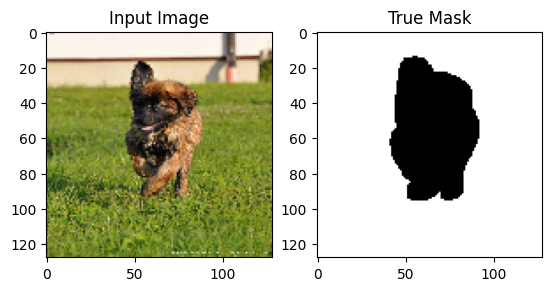

In [ ]:
# Visualize example
for image, mask in test_dataset.take(1):
    plt.subplot(1, 2, 1)
    plt.title('Input Image')
    plt.imshow(image[0])

    plt.subplot(1, 2, 2)
    plt.title('True Mask')
    plt.imshow(mask[0], cmap='gray')
    plt.show()

CNN training

In [ ]:
# Build the U-Net model
model = build_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[iou])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
# Train the model
history = model.fit(train_dataset, epochs=1, validation_data=test_dataset)

Epoch 1/2
115/115 [==============================] - 4625s 40s/step - loss: 0.6114 - iou: 0.3664 - val_loss: 0.5199 - val_iou: 0.4152
Epoch 2/2
115/115 [==============================] - 4653s 41s/step - loss: 0.5144 - iou: 0.4109 - val_loss: 0.4766 - val_iou: 0.4130


1/1 [==============================] - 11s 11s/step


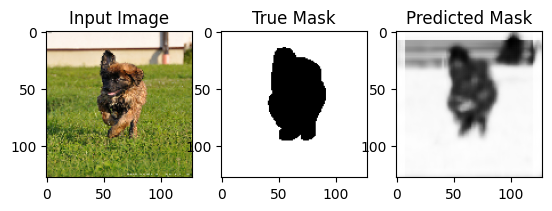

In [ ]:
# Visualize example predictions
for image, mask in test_dataset.take(1):
    predicted_mask = model.predict(image)
    plt.subplot(1, 3, 1)
    plt.title('Input Image')
    plt.imshow(image[0])

    plt.subplot(1, 3, 2)
    plt.title('True Mask')
    plt.imshow(mask[0], cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(predicted_mask[0][:, :, 0], cmap='gray')
    plt.show()